In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd ./drive/MyDrive/cs5344

/content/drive/MyDrive/cs5344


**environment**

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D, Flatten
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#!pip install tensorflow-addons
#!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**read data**

In [ ]:
def score_label(score):
    if score > 1/3: return 1
    elif score < -1/3: return -1
    else: return 0

data_path = 'convincing_data.csv'
data = pd.read_csv(data_path)
data['body_cleaned'] = data['body_cleaned'].apply(lambda x: x.strip('[]').replace("'",'').split(', '))
data ['text'] = data['body_cleaned'].apply(lambda x: ' '.join(x))
data = data[['id','text','sentiment']]
data['sentiment'] = data['sentiment'].apply(lambda x: score_label(x))

**word_embedding**

set maxlen = 2183 (95% text length, covers the majority of text lengths)

In [ ]:


X = data['text'].values
y = data['sentiment'].values

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=42)

# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences to the same length
maxlen = 2183
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Convert labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Build model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=500, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history6 = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)


Epoch 1/50
8867/8867 [==============================] - 859s 96ms/step - loss: 0.6747 - accuracy: 0.7215 - val_loss: 0.6261 - val_accuracy: 0.7412
Epoch 2/50
8867/8867 [==============================] - 723s 82ms/step - loss: 0.6091 - accuracy: 0.7535 - val_loss: 0.6067 - val_accuracy: 0.7516
Epoch 3/50
8867/8867 [==============================] - 720s 81ms/step - loss: 0.5686 - accuracy: 0.7701 - val_loss: 0.6097 - val_accuracy: 0.7474
Epoch 4/50
8867/8867 [==============================] - 715s 81ms/step - loss: 0.5288 - accuracy: 0.7859 - val_loss: 0.6247 - val_accuracy: 0.7435
Epoch 5/50
2217/2217 [==============================] - 23s 10ms/step


In [ ]:
def plot_history(history, method, metric='loss', file_prefix=''):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']
    epochs = range(1, len(train_metric) + 1)

    plt.figure(figsize=(6, 4.5))
    plt.grid(linestyle="-")
    ax = plt.gca()
    plt.plot(epochs, train_metric, color="#0DAB76", label=f"Train {metric.capitalize()}", linewidth=1.5)
    plt.plot(epochs, val_metric, color="#F487B6", label=f"Validation {metric.capitalize()}", linewidth=1.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.xlabel("#Epochs", fontsize=12)
    plt.xlim(0, 6)  # range of x
    plt.ylim(0.4, 1)  # range of y

    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12)

    plt.title(f'{method} {metric.capitalize()}')

    plt.savefig(f'./{file_prefix}{method}_{metric}.pdf', format='pdf')  # save as pdf, then screen capture
    plt.show()

In [ ]:
# Output classification report
print(classification_report(y_test, y_pred, target_names=['0', '1', '-1']))

              precision    recall  f1-score   support

           0       0.62      0.30      0.40     11900
           1       0.77      0.83      0.80     29242
          -1       0.76      0.85      0.80     29782

    accuracy                           0.75     70924
   macro avg       0.72      0.66      0.67     70924
weighted avg       0.74      0.75      0.74     70924



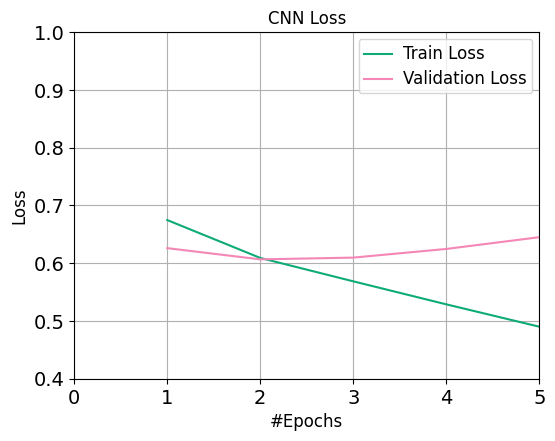

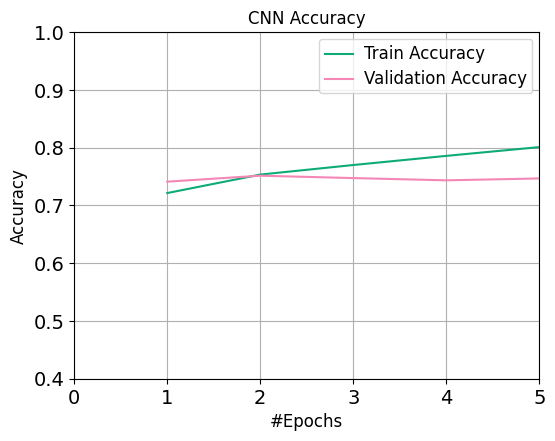

In [ ]:
method = 'CNN'
plot_history(history6, method, metric='loss', file_prefix='')
plot_history(history6, method, metric='accuracy', file_prefix='')

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

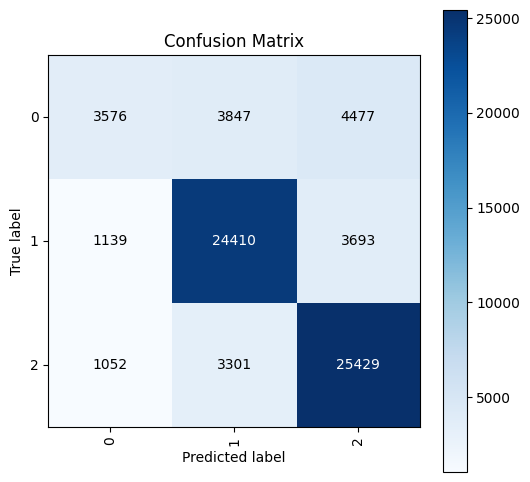

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(6,6),x_tick_rotation=90)

set maxlen = 500

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

X = data['text'].values
y = data['sentiment'].values

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=42)

# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences to the same length
maxlen = 500
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Convert labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Build model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=500, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history5 = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)


Epoch 1/50
8867/8867 [==============================] - 258s 29ms/step - loss: 0.6732 - accuracy: 0.7229 - val_loss: 0.6140 - val_accuracy: 0.7467
Epoch 2/50
8867/8867 [==============================] - 171s 19ms/step - loss: 0.6097 - accuracy: 0.7532 - val_loss: 0.6058 - val_accuracy: 0.7508
Epoch 3/50
8867/8867 [==============================] - 167s 19ms/step - loss: 0.5689 - accuracy: 0.7701 - val_loss: 0.6148 - val_accuracy: 0.7495
Epoch 4/50
8867/8867 [==============================] - 167s 19ms/step - loss: 0.5291 - accuracy: 0.7855 - val_loss: 0.6700 - val_accuracy: 0.7454
Epoch 5/50
2217/2217 [==============================] - 7s 3ms/step


In [ ]:
# Output classification report
print(classification_report(y_test, y_pred, target_names=['0', '1', '-1']))

              precision    recall  f1-score   support

           0       0.64      0.28      0.39     11900
           1       0.77      0.84      0.80     29242
          -1       0.75      0.85      0.80     29782

    accuracy                           0.75     70924
   macro avg       0.72      0.66      0.66     70924
weighted avg       0.74      0.75      0.73     70924



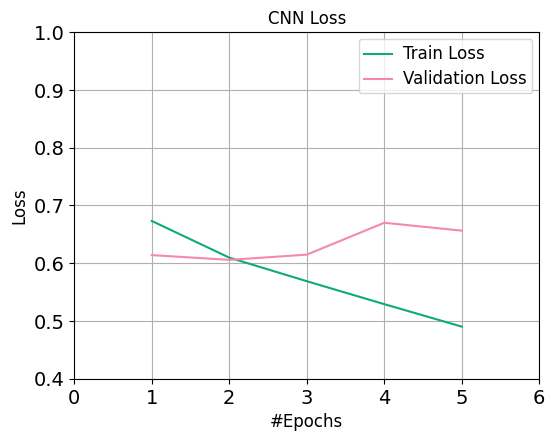

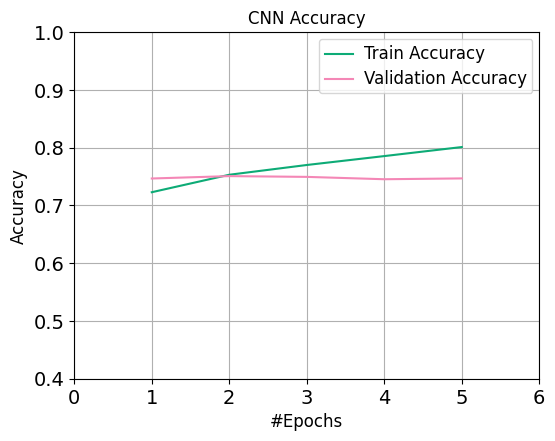

In [ ]:
method = 'CNN'
plot_history(history5, method, metric='loss', file_prefix='')
plot_history(history5, method, metric='accuracy', file_prefix='')

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

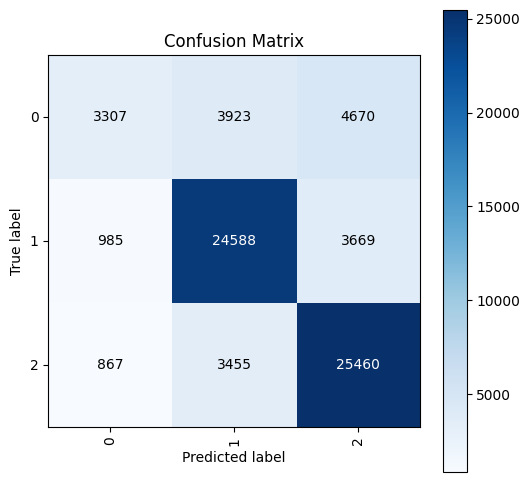

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(6,6),x_tick_rotation=90)

based on split3 and split4 (although not fit for cnn input)

In [ ]:

# def split1(df):
#     random.seed(42)
#     np.random.seed(42)
#     X = df['text']
#     y = df['sentiment']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     vectorizer = CountVectorizer()
#     X_train_vectorized = vectorizer.fit_transform(X_train)
#     X_test_vectorized = vectorizer.transform(X_test)
#     print("X_train.shape: ", X_train_vectorized.shape)
#     print("X_test.shape: ", X_test_vectorized.shape)
#     return X_train_vectorized, X_test_vectorized, y_train, y_test

# def split2(df):
#     random.seed(42)
#     np.random.seed(42)
#     X = df['text']
#     y = df['sentiment']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     vectorizer = TfidfVectorizer()
#     X_train_vectorized = vectorizer.fit_transform(X_train)
#     X_test_vectorized = vectorizer.transform(X_test)
#     print("X_train.shape: ", X_train_vectorized.shape)
#     print("X_test.shape: ", X_test_vectorized.shape)
#     return X_train_vectorized, X_test_vectorized, y_train, y_test

def split3(df, dimension):
    random.seed(42)
    np.random.seed(42)
    X = df['text']
    y = df['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    svd = TruncatedSVD(n_components=dimension)
    X_train = svd.fit_transform(X_train_vectorized)
    X_test = svd.transform(X_test_vectorized)
    print("X_train.shape: ", X_train.shape)
    print("X_test.shape: ", X_test.shape)
    plt.plot(np.cumsum(svd.explained_variance_ratio_))
    return X_train, X_test, y_train, y_test


def split4(df, dimension):
    random.seed(42)
    np.random.seed(42)
    X = df['text']
    y = df['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    vectorizer = TfidfVectorizer(max_features=dimension)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    X_train = X_train_vectorized.toarray()
    X_test = X_test_vectorized.toarray()
    print("X_train.shape: ", X_train.shape)
    print("X_test.shape: ", X_test.shape)
    return X_train, X_test, y_train, y_test



split4

In [ ]:
from tensorflow.keras.utils import to_categorical

# build model for split4
def create_cnn_model_for_split4(input_length, num_classes):
    input_layer = Input(shape=(input_length,))
    reshape_layer = Reshape((input_length, 1))(input_layer)
    conv1d_layer = Conv1D(filters=128, kernel_size=3, activation='relu')(reshape_layer)
    global_max_pooling1d_layer = GlobalMaxPooling1D()(conv1d_layer)
    dense_layer = Dense(units=64, activation='relu')(global_max_pooling1d_layer)
    dropout_layer = Dropout(0.5)(dense_layer)
    output_layer = Dense(units=num_classes, activation='softmax')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# 使用split4函数进行数据划分
X_train, X_test, y_train, y_test = split4(data, dimension=1000)

X_train.shape:  (638313, 1000)
X_test.shape:  (70924, 1000)


In [ ]:
from tensorflow.keras.callbacks import History

# create an instance of the History callback
history2 = History()


input_length = X_train.shape[1]

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Reshape

# encode
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

# build model
cnn_model = create_cnn_model_for_split4(input_length, len(le.classes_))

# train model
history2 = cnn_model.fit(X_train, y_train_onehot, epochs=50, batch_size=64, verbose=1, validation_data=(X_test, y_test_onehot), callbacks=[history2])


# predict
y_pred = cnn_model.predict(X_test).argmax(axis=1)

# transform back
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test_encoded)


# output: classification_report
print(classification_report(y_test_labels, y_pred_labels))

Epoch 1/50
9974/9974 [==============================] - 49s 4ms/step - loss: 1.0277 - accuracy: 0.4192 - val_loss: 1.0230 - val_accuracy: 0.4242
Epoch 2/50
9974/9974 [==============================] - 39s 4ms/step - loss: 1.0247 - accuracy: 0.4253 - val_loss: 1.0205 - val_accuracy: 0.4281
Epoch 3/50
9974/9974 [==============================] - 39s 4ms/step - loss: 1.0236 - accuracy: 0.4270 - val_loss: 1.0191 - val_accuracy: 0.4291
Epoch 4/50
9974/9974 [==============================] - 39s 4ms/step - loss: 1.0231 - accuracy: 0.4270 - val_loss: 1.0184 - val_accuracy: 0.4309
Epoch 5/50
9974/9974 [==============================] - 39s 4ms/step - loss: 1.0228 - accuracy: 0.4279 - val_loss: 1.0184 - val_accuracy: 0.4211
Epoch 6/50
9974/9974 [==============================] - 39s 4ms/step - loss: 1.0225 - accuracy: 0.4277 - val_loss: 1.0208 - val_accuracy: 0.4299
Epoch 7/50
9974/9974 [==============================] - 39s 4ms/step - loss: 1.0224 - accuracy: 0.4280 - val_loss: 1.0180 - val_ac

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


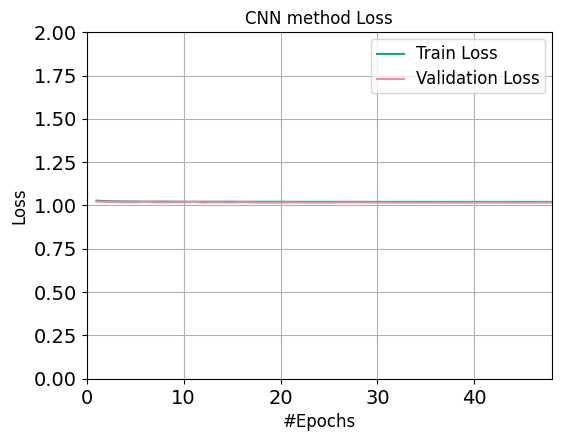

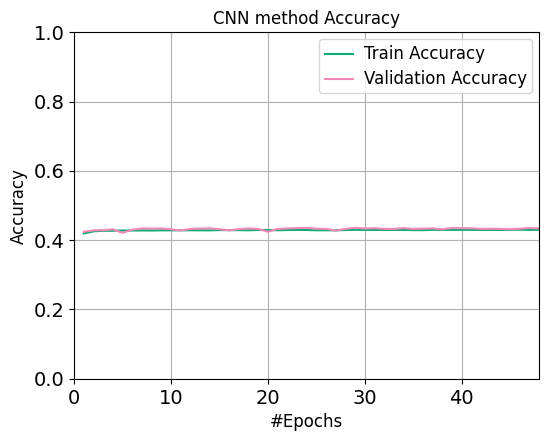

In [ ]:
# Get the training history
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc= history2.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)


# Plot the training history
import matplotlib.pyplot as plt

method = 'CNN method' #method name

plt.figure(figsize=(6, 4.5))
plt.grid(linestyle="-")  
ax = plt.gca()
plt.plot(epochs, train_loss, color="#0DAB76", label="Train Loss", linewidth=1.5)
plt.plot(epochs, val_loss, color="#F487B6", label="Validation Loss", linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("#Epochs", fontsize=12)
plt.xlim(0, 48) # range of x
plt.ylim(0, 2) # range of y

plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

plt.title(method + ' Loss')

plt.savefig('./' + method + '_loss.pdf', format='pdf')  # save as pdf, then screen capture
plt.show()

plt.figure(figsize=(6, 4.5))
plt.grid(linestyle="-")  
ax = plt.gca()
plt.plot(epochs, train_acc, color="#0DAB76", label="Train Accuracy", linewidth=1.5)
plt.plot(epochs, val_acc, color="#F487B6", label="Validation Accuracy", linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("#Epochs", fontsize=12)
plt.xlim(0, 48) # range of x
plt.ylim(0, 1) # range of y

plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

plt.title(method + ' Accuracy')

plt.savefig('./'+method+'_acc.pdf', format='pdf')  # save as pdf, then screen capture
plt.show()

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

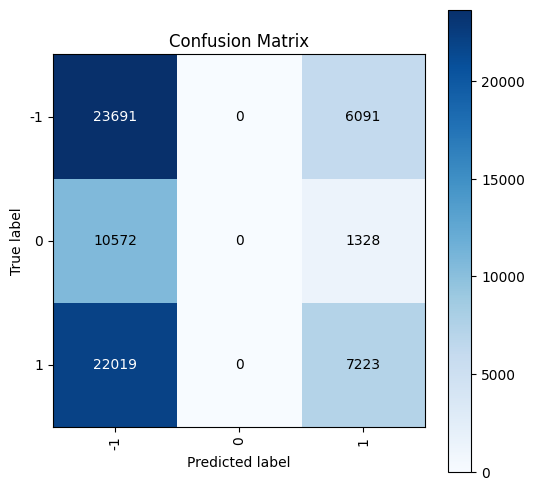

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test_labels, 
    y_pred_labels,
    figsize=(6,6),x_tick_rotation=90)

split3 + 128 Conv1D + 0.5 Dropout(old)

In [ ]:
def create_cnn_model_for_split3(input_length, num_classes):
    input_layer = Input(shape=(input_length,))
    reshape_layer = Reshape((input_length, 1))(input_layer)
    conv1d_layer = Conv1D(filters=128, kernel_size=3, activation='relu')(reshape_layer)
    global_max_pooling1d_layer = GlobalMaxPooling1D()(conv1d_layer)
    dense_layer = Dense(units=64, activation='relu')(global_max_pooling1d_layer)
    dropout_layer = Dropout(0.5)(dense_layer)
    output_layer = Dense(units=num_classes, activation='softmax')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

X_train.shape:  (638313, 500)
X_test.shape:  (70924, 500)
Epoch 1/50
9974/9974 [==============================] - 192s 19ms/step - loss: 0.9942 - accuracy: 0.4588 - val_loss: 0.9807 - val_accuracy: 0.4670
Epoch 2/50
9974/9974 [==============================] - 187s 19ms/step - loss: 0.9889 - accuracy: 0.4633 - val_loss: 0.9792 - val_accuracy: 0.4685
Epoch 3/50
9974/9974 [==============================] - 185s 19ms/step - loss: 0.9877 - accuracy: 0.4656 - val_loss: 0.9780 - val_accuracy: 0.4710
Epoch 4/50
9974/9974 [==============================] - 186s 19ms/step - loss: 0.9874 - accuracy: 0.4657 - val_loss: 0.9789 - val_accuracy: 0.4749
Epoch 5/50
9974/9974 [==============================] - 188s 19ms/step - loss: 0.9868 - accuracy: 0.4658 - val_loss: 0.9773 - val_accuracy: 0.4733
Epoch 6/50
9974/9974 [==============================] - 182s 18ms/step - loss: 0.9861 - accuracy: 0.4662 - val_loss: 0.9773 - val_accuracy: 0.4719
Epoch 7/50
9974/9974 [==============================] - 190s

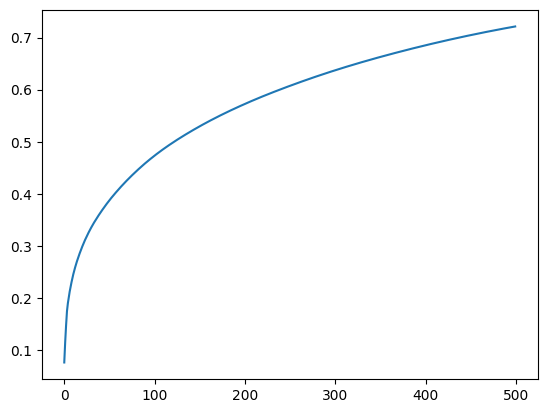

In [ ]:
# create an instance of the History callback
history = History()

# split
X_train, X_test, y_train, y_test = split3(data, dimension=500)

input_length = X_train.shape[1]

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Reshape
# encode
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

# create model
cnn_model = create_cnn_model_for_split3(input_length, len(le.classes_))

# train model
history = cnn_model.fit(X_train, y_train_onehot, epochs=50, batch_size=64, verbose=1, validation_data=(X_test, y_test_onehot), callbacks=[history])


# predict
y_pred = cnn_model.predict(X_test).argmax(axis=1)

# transform back
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test_encoded)

# output: classification_report
print(classification_report(y_test_labels, y_pred_labels))

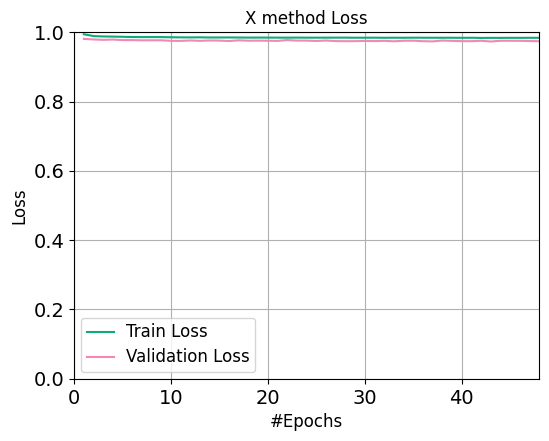

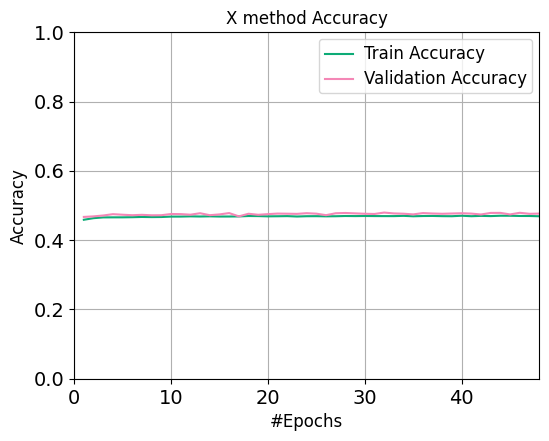

In [ ]:
# Get the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)


method = 'X method' #method name

plt.figure(figsize=(6, 4.5))
plt.grid(linestyle="-")  
ax = plt.gca()
plt.plot(epochs, train_loss, color="#0DAB76", label="Train Loss", linewidth=1.5)
plt.plot(epochs, val_loss, color="#F487B6", label="Validation Loss", linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("#Epochs", fontsize=12)
plt.xlim(0, 48) # range of x
plt.ylim(0, 1) # range of y

plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

plt.title(method + ' Loss')

plt.savefig('./' + method + '_loss.pdf', format='pdf')  # save as pdf, then screen capture
plt.show()

plt.figure(figsize=(6, 4.5))
plt.grid(linestyle="-")  
ax = plt.gca()
plt.plot(epochs, train_acc, color="#0DAB76", label="Train Accuracy", linewidth=1.5)
plt.plot(epochs, val_acc, color="#F487B6", label="Validation Accuracy", linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("#Epochs", fontsize=12)
plt.xlim(0, 48) # range of x
plt.ylim(0, 1) # range of y

plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

plt.title(method + ' Accuracy')

plt.savefig('./'+method+'_acc.pdf', format='pdf')  # save as pdf, then screen capture
plt.show()

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

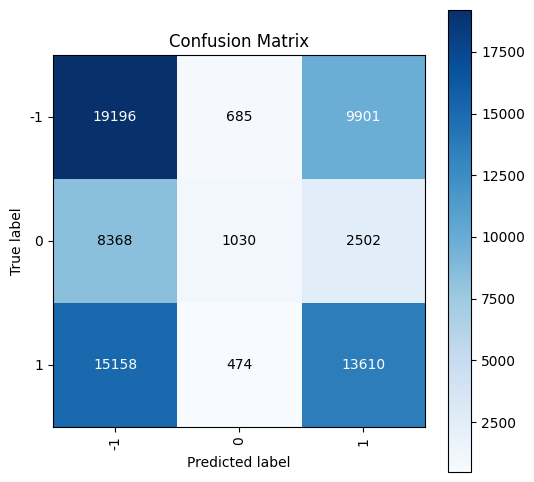

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test_labels, 
    y_pred_labels,
    figsize=(6,6),x_tick_rotation=90)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

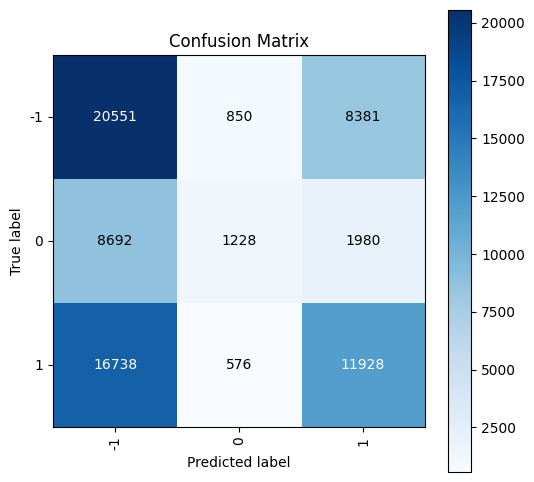

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test_labels, 
    y_pred_labels,
    figsize=(6,6),x_tick_rotation=90)

split3 + 128 Conv1D + 0.5 Dropout(old)

X_train.shape:  (638313, 500)
X_test.shape:  (70924, 500)
Epoch 1/10
9974/9974 - 227s - loss: 0.9938 - accuracy: 0.4592 - 227s/epoch - 23ms/step
Epoch 2/10
9974/9974 - 234s - loss: 0.9887 - accuracy: 0.4639 - 234s/epoch - 24ms/step
Epoch 3/10
9974/9974 - 236s - loss: 0.9874 - accuracy: 0.4661 - 236s/epoch - 24ms/step
Epoch 4/10
9974/9974 - 232s - loss: 0.9869 - accuracy: 0.4666 - 232s/epoch - 23ms/step
Epoch 5/10
9974/9974 - 229s - loss: 0.9865 - accuracy: 0.4671 - 229s/epoch - 23ms/step
Epoch 6/10
9974/9974 - 230s - loss: 0.9865 - accuracy: 0.4665 - 230s/epoch - 23ms/step
Epoch 7/10
9974/9974 - 230s - loss: 0.9862 - accuracy: 0.4675 - 230s/epoch - 23ms/step
Epoch 8/10
9974/9974 - 230s - loss: 0.9859 - accuracy: 0.4672 - 230s/epoch - 23ms/step
Epoch 9/10
9974/9974 - 230s - loss: 0.9855 - accuracy: 0.4675 - 230s/epoch - 23ms/step
Epoch 10/10
9974/9974 - 231s - loss: 0.9855 - accuracy: 0.4679 - 231s/epoch - 23ms/step
2217/2217 [==============================] - 8s 4ms/step
              

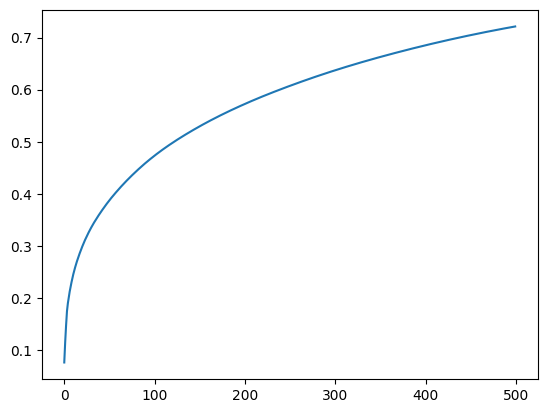

In [ ]:
X_train, X_test, y_train, y_test = split3(data, dimension=500)

input_length = X_train.shape[1]

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Reshape
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

cnn_model = create_cnn_model_for_split3(input_length, len(le.classes_))

cnn_model.fit(X_train, y_train_onehot, epochs=10, batch_size=64, verbose=2)

y_pred = cnn_model.predict(X_test).argmax(axis=1)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test_encoded)

print(classification_report(y_test_labels, y_pred_labels))

split3 + 256 Conv1D + 0.2 Dropout

In [ ]:
from tensorflow.keras.utils import to_categorical

def create_cnn_model_for_split3(input_length, num_classes):
    input_layer = Input(shape=(input_length,))
    reshape_layer = Reshape((input_length, 1))(input_layer)
    conv1d_layer = Conv1D(filters=256, kernel_size=3, activation='relu')(reshape_layer)
    global_max_pooling1d_layer = GlobalMaxPooling1D()(conv1d_layer)
    dense_layer = Dense(units=64, activation='relu')(global_max_pooling1d_layer)
    dropout_layer = Dropout(0.2)(dense_layer)
    output_layer = Dense(units=num_classes, activation='softmax')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

X_train.shape:  (638313, 500)
X_test.shape:  (70924, 500)
Epoch 1/10
9974/9974 - 474s - loss: 0.9875 - accuracy: 0.4641 - 474s/epoch - 48ms/step
Epoch 2/10
9974/9974 - 486s - loss: 0.9838 - accuracy: 0.4685 - 486s/epoch - 49ms/step
Epoch 3/10
9974/9974 - 490s - loss: 0.9828 - accuracy: 0.4698 - 490s/epoch - 49ms/step
Epoch 4/10
9974/9974 - 480s - loss: 0.9825 - accuracy: 0.4703 - 480s/epoch - 48ms/step
Epoch 5/10
9974/9974 - 481s - loss: 0.9818 - accuracy: 0.4708 - 481s/epoch - 48ms/step
Epoch 6/10
9974/9974 - 484s - loss: 0.9815 - accuracy: 0.4718 - 484s/epoch - 49ms/step
Epoch 7/10
9974/9974 - 480s - loss: 0.9812 - accuracy: 0.4719 - 480s/epoch - 48ms/step
Epoch 8/10
9974/9974 - 488s - loss: 0.9810 - accuracy: 0.4724 - 488s/epoch - 49ms/step
Epoch 9/10
9974/9974 - 486s - loss: 0.9807 - accuracy: 0.4726 - 486s/epoch - 49ms/step
Epoch 10/10
9974/9974 - 495s - loss: 0.9806 - accuracy: 0.4726 - 495s/epoch - 50ms/step
2217/2217 [==============================] - 15s 7ms/step
             

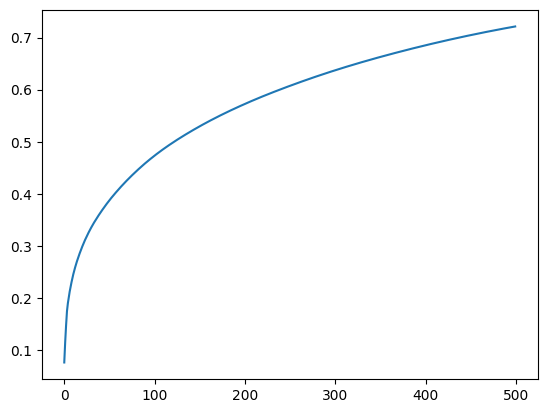

In [ ]:
X_train, X_test, y_train, y_test = split3(data, dimension=500)

input_length = X_train.shape[1]

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Reshape

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

cnn_model = create_cnn_model_for_split3(input_length, len(le.classes_))

cnn_model.fit(X_train, y_train_onehot, epochs=10, batch_size=64, verbose=2)

y_pred = cnn_model.predict(X_test).argmax(axis=1)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test_encoded)

print(classification_report(y_test_labels, y_pred_labels))